# Visualize Signature enrichment for ADAGE models on RNAseq data

### Georgia Doing 2021

After training models (see seqADAGE_train_param_search.ipynb), calculate and plot signature enrichment of KEGG, etc., to assess the models. This file in particular looks at models used to create an ensemble model with MR normalized RNA-seq data (seeds 660 - 759).

### 1. Setup and Load data
    
    1.1 libraries and reload for dev
    1.2 load ADAGE trained on array data with Jie's original code
### 2. Load models from files

    2.1 With seed 660, load mdoels with different params

### 3. Plots
    3.1 Plots loss curves
    3.2 Print out validation loss minumums
    3.3 3.3 Plot node weight distributions

    
### 4. Calculate High weight gene / signature enrichment

### 5. Plot signature enrichments

### 6. Load Replicate models (3 different seeds per param combo)
    6.1 Load models
    6.2 Plots loss
    6.3 Loss mins
    6.4 Plot weights
    6.5 Calc enrichments
    6.6 Plot enrichments
    6.7 Plots enrichmetns of positive sigs
    6.8 Plot enrichments of negetive sigs

### 7. Load 10 reps for final model selection
    7.1 Load models
    7.2 Plot loss
    7.3 Plot weights
    7.4 Calculate enrichments
    7.5 Plot enrichments
    7.6 Save enrichments to files
    7.7 Write out high weight gene lists/weights

## 1. Setup and load data

### 1.1 Load lirbaries and RNA-seq compendium

In [2]:
import run_count_autoencoder
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
from scipy.stats import hypergeom
import csv
import TiedWeightsEncoder

In [3]:
# for dev purposes, while updating run_model.py need to reload
reload(run_count_autoencoder)
reload(run_model)
reload(Adage)
reload(TiedWeightsEncoder)

<module 'TiedWeightsEncoder' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/TiedWeightsEncoder.py'>

### 1.2 Load model trained on array data, using original ADAGE code

In [3]:
m = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log.csv',lr=.0001,seed=460,kl1=1e-10,kl2=1e-1, act = 'sigmoid', tied = True, epochs=5, init='glorot_uniform', batch_size=10, v=0)
tf_adage = Adage.Adage(m.autoencoder, m.history, m.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(5549, 600)

## 2.0 LOAD MODELS FROM FILES

### 2.1 Seed 660, different params
Note that seed is 660 and we are loading models with different parameters but all trained on the same compendium"

pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_byall

In [66]:
inits = ['glorot_uniform','glorot_normal']
L1_norm = [0, 1e-5, 1e-10] # 
L2_norm = [0, 1e-5, 1e-10]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.0001] 

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,



model_dict_da = {
    "tf_adage": tf_adage
}

#model_dict_da_normed = {
#    "tf_adage": tf_adage
#}

#model_dict_da_normed_sub = {
#    "tf_adage": tf_adage
#}


for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        seed = str(660)
                        name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                        #model_dict_da
                        prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_byall_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                        #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                        #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_bygene_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                        try:
                            weights_temp = np.array(pd.read_csv('../outputs/weights/' + prefix + '_en_weights_da.csv', header = None))
                            loss_temp = np.array(pd.read_csv('../outputs/loss/' + prefix + '_loss_da.csv', header = None))
                            val_loss_temp = np.array(pd.read_csv('../outputs/val_loss/' + prefix + '_val_loss_da.csv', header = None))
                            adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                            adage_temp.weights = weights_temp
                            adage_temp.loss = loss_temp[0]
                            adage_temp.val_loss = val_loss_temp[0]
                            adage_temp.set_hwg_cutoff(2.5)
                            model_dict_da[name] = adage_temp
                            #model_dict_da_normed[name] = adage_temp
                            #model_dict_da_normed_sub[name] = adage_temp
                        except:
                            print(name)
                            adage_temp = tf_adage
                            adage_temp.loss = [0] * 250
                            adage_temp.val_loss = [0] * 250
                            adage_temp.weights = np.zeros(tf_adage.weights.shape)
                            model_dict_da[name] = adage_temp
                            #model_dict_da_normed[name] = adage_temp
                            #model_dict_da_normed_sub[name] = adage_temp
                        





## 3. PLOTS

### 3.1 Plots of training and validation loss curves

In [ ]:
RNAseq DA

0.606391191482544
0.9543583393096924


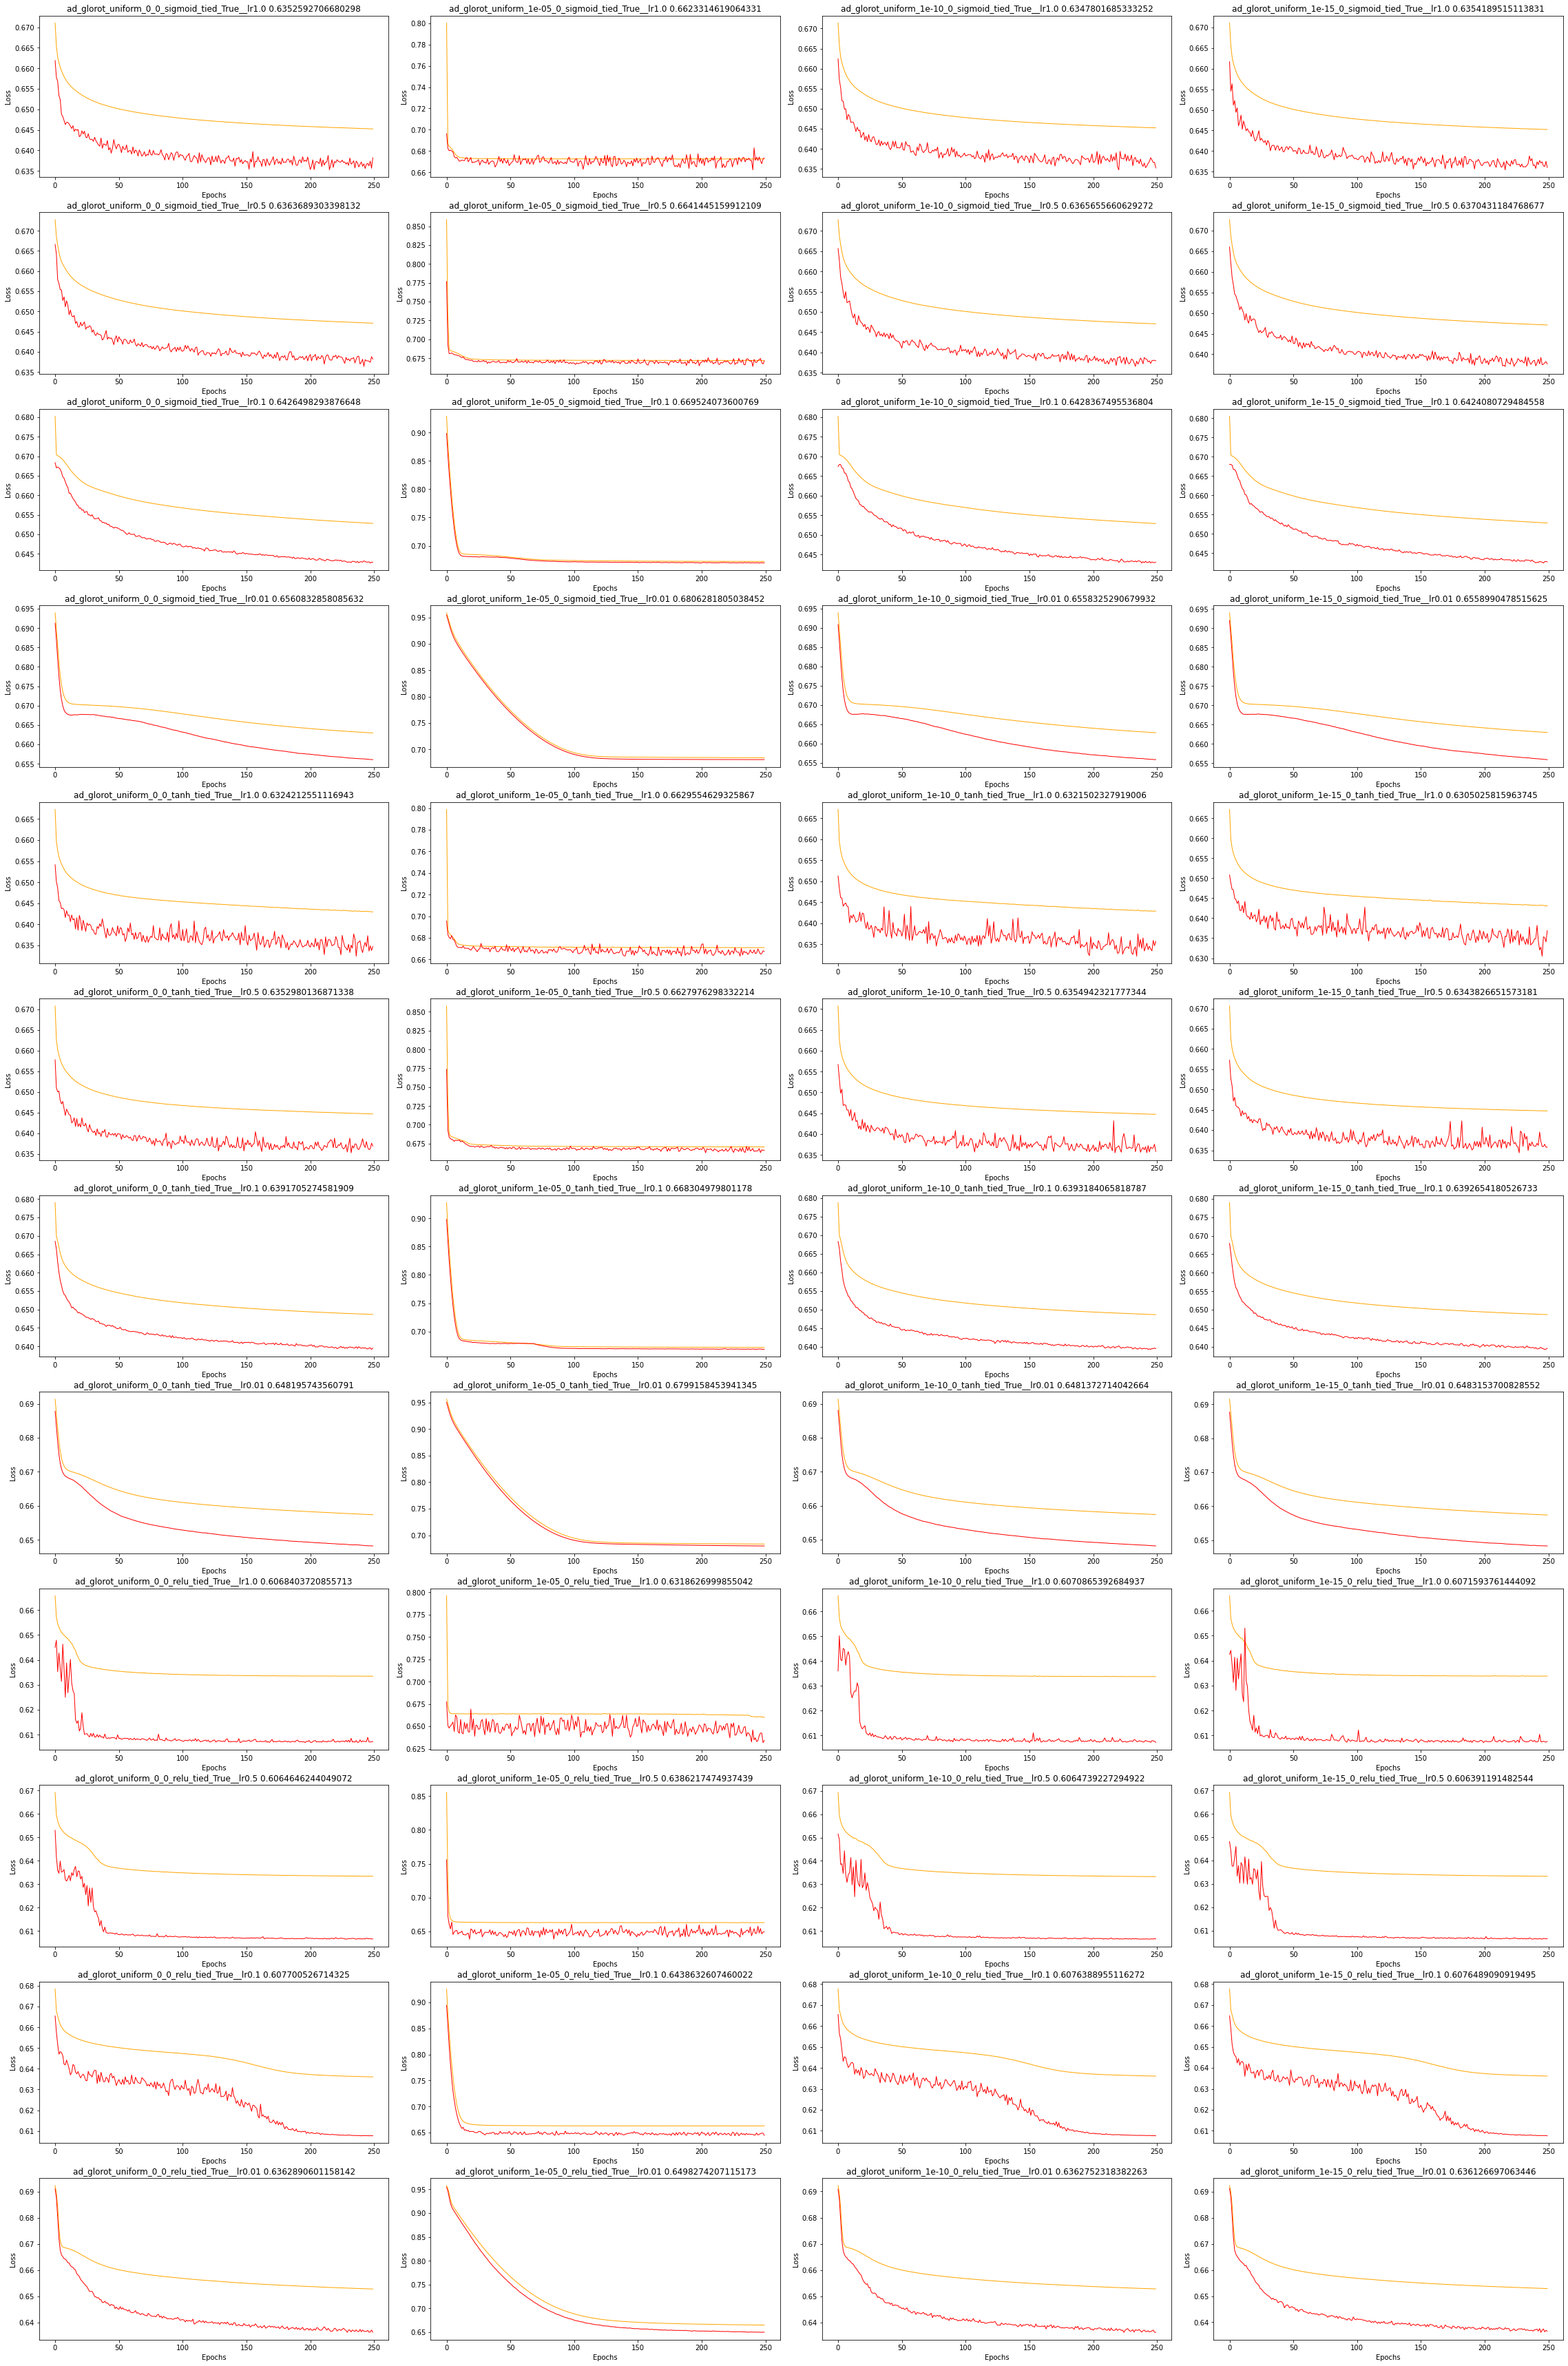

In [73]:
model_dict_temp = model_dict_da
#model_dict_temp = model_dict_da_normed
#model_dict_temp = model_dict_da_normed_sub
minn=float('inf')
for mo in model_dict_temp.keys():
    minn_t = min(model_dict_temp[mo].val_loss)
    if(minn_t > 0):
        minn = min(minn, minn_t)

maxx=float('-inf')
for mo in model_dict_temp.keys():
    maxx_t = max(model_dict_temp[mo].val_loss)
    maxx = max(maxx, maxx_t)

print(minn)
print(maxx)

val_loss_mins = {}
for mo in model_dict_temp.keys():
    val_loss_mins[mo] = min(model_dict_temp[mo].val_loss)
    
    
inits = ['glorot_uniform'] #,'glorot_normal'
L1_norm = [0, 1e-5] # , 1e-10
L2_norm = [0, 1e-5] # , 1e-10
act_fun = ['sigmoid', 'tanh', 'relu'] # , 'tanh','relu'
tied = [True] #, False
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.0001] 

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,

yd = len(inits) * len(L1_norm) * len(tied) * len(L2_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        seed = str(660)
                        name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                        model_temp = model_dict_temp[name]
                        ax[xi,yi].plot(list(range(0,250)), model_temp.loss[:250], linewidth=1, markersize=2, color = 'orange')
                        ax[xi,yi].plot(list(range(0,250)), model_temp.val_loss[:250], linewidth=1, markersize=2, color = 'red')
                        ax[xi,yi].set(title = name + " " + str(val_loss_mins[name]), xlabel = 'Epochs', ylabel = 'Loss')
                        #ax[xi,yi].set_ylim(minn,maxx)
                        xi = xi+1
                xi=0
                yi=yi+1


    

### 3.2 Print out validation loss minumums

In [72]:
val_loss_mins = {}
for mo in model_dict_temp.keys():
    val_loss_mins[mo] = min(model_dict_temp[mo].val_loss)
val_loss_mins

{'tf_adage': 0,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0': 0.6352592706680298,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5': 0.6363689303398132,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1': 0.6426498293876648,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01': 0.6560832858085632,
 'ad_glorot_uniform_0_0_tanh_tied_True__lr1.0': 0.6324212551116943,
 'ad_glorot_uniform_0_0_tanh_tied_True__lr0.5': 0.6352980136871338,
 'ad_glorot_uniform_0_0_tanh_tied_True__lr0.1': 0.6391705274581909,
 'ad_glorot_uniform_0_0_tanh_tied_True__lr0.01': 0.648195743560791,
 'ad_glorot_uniform_0_0_relu_tied_True__lr1.0': 0.6068403720855713,
 'ad_glorot_uniform_0_0_relu_tied_True__lr0.5': 0.6064646244049072,
 'ad_glorot_uniform_0_0_relu_tied_True__lr0.1': 0.607700526714325,
 'ad_glorot_uniform_0_0_relu_tied_True__lr0.01': 0.6362890601158142,
 'ad_glorot_uniform_1e-05_0_sigmoid_tied_True__lr1.0': 0.6623314619064331,
 'ad_glorot_uniform_1e-05_0_sigmoid_tied_True__lr0.5': 0.6641445159912109,
 'ad_

### 3.3 Plot node weight distributions

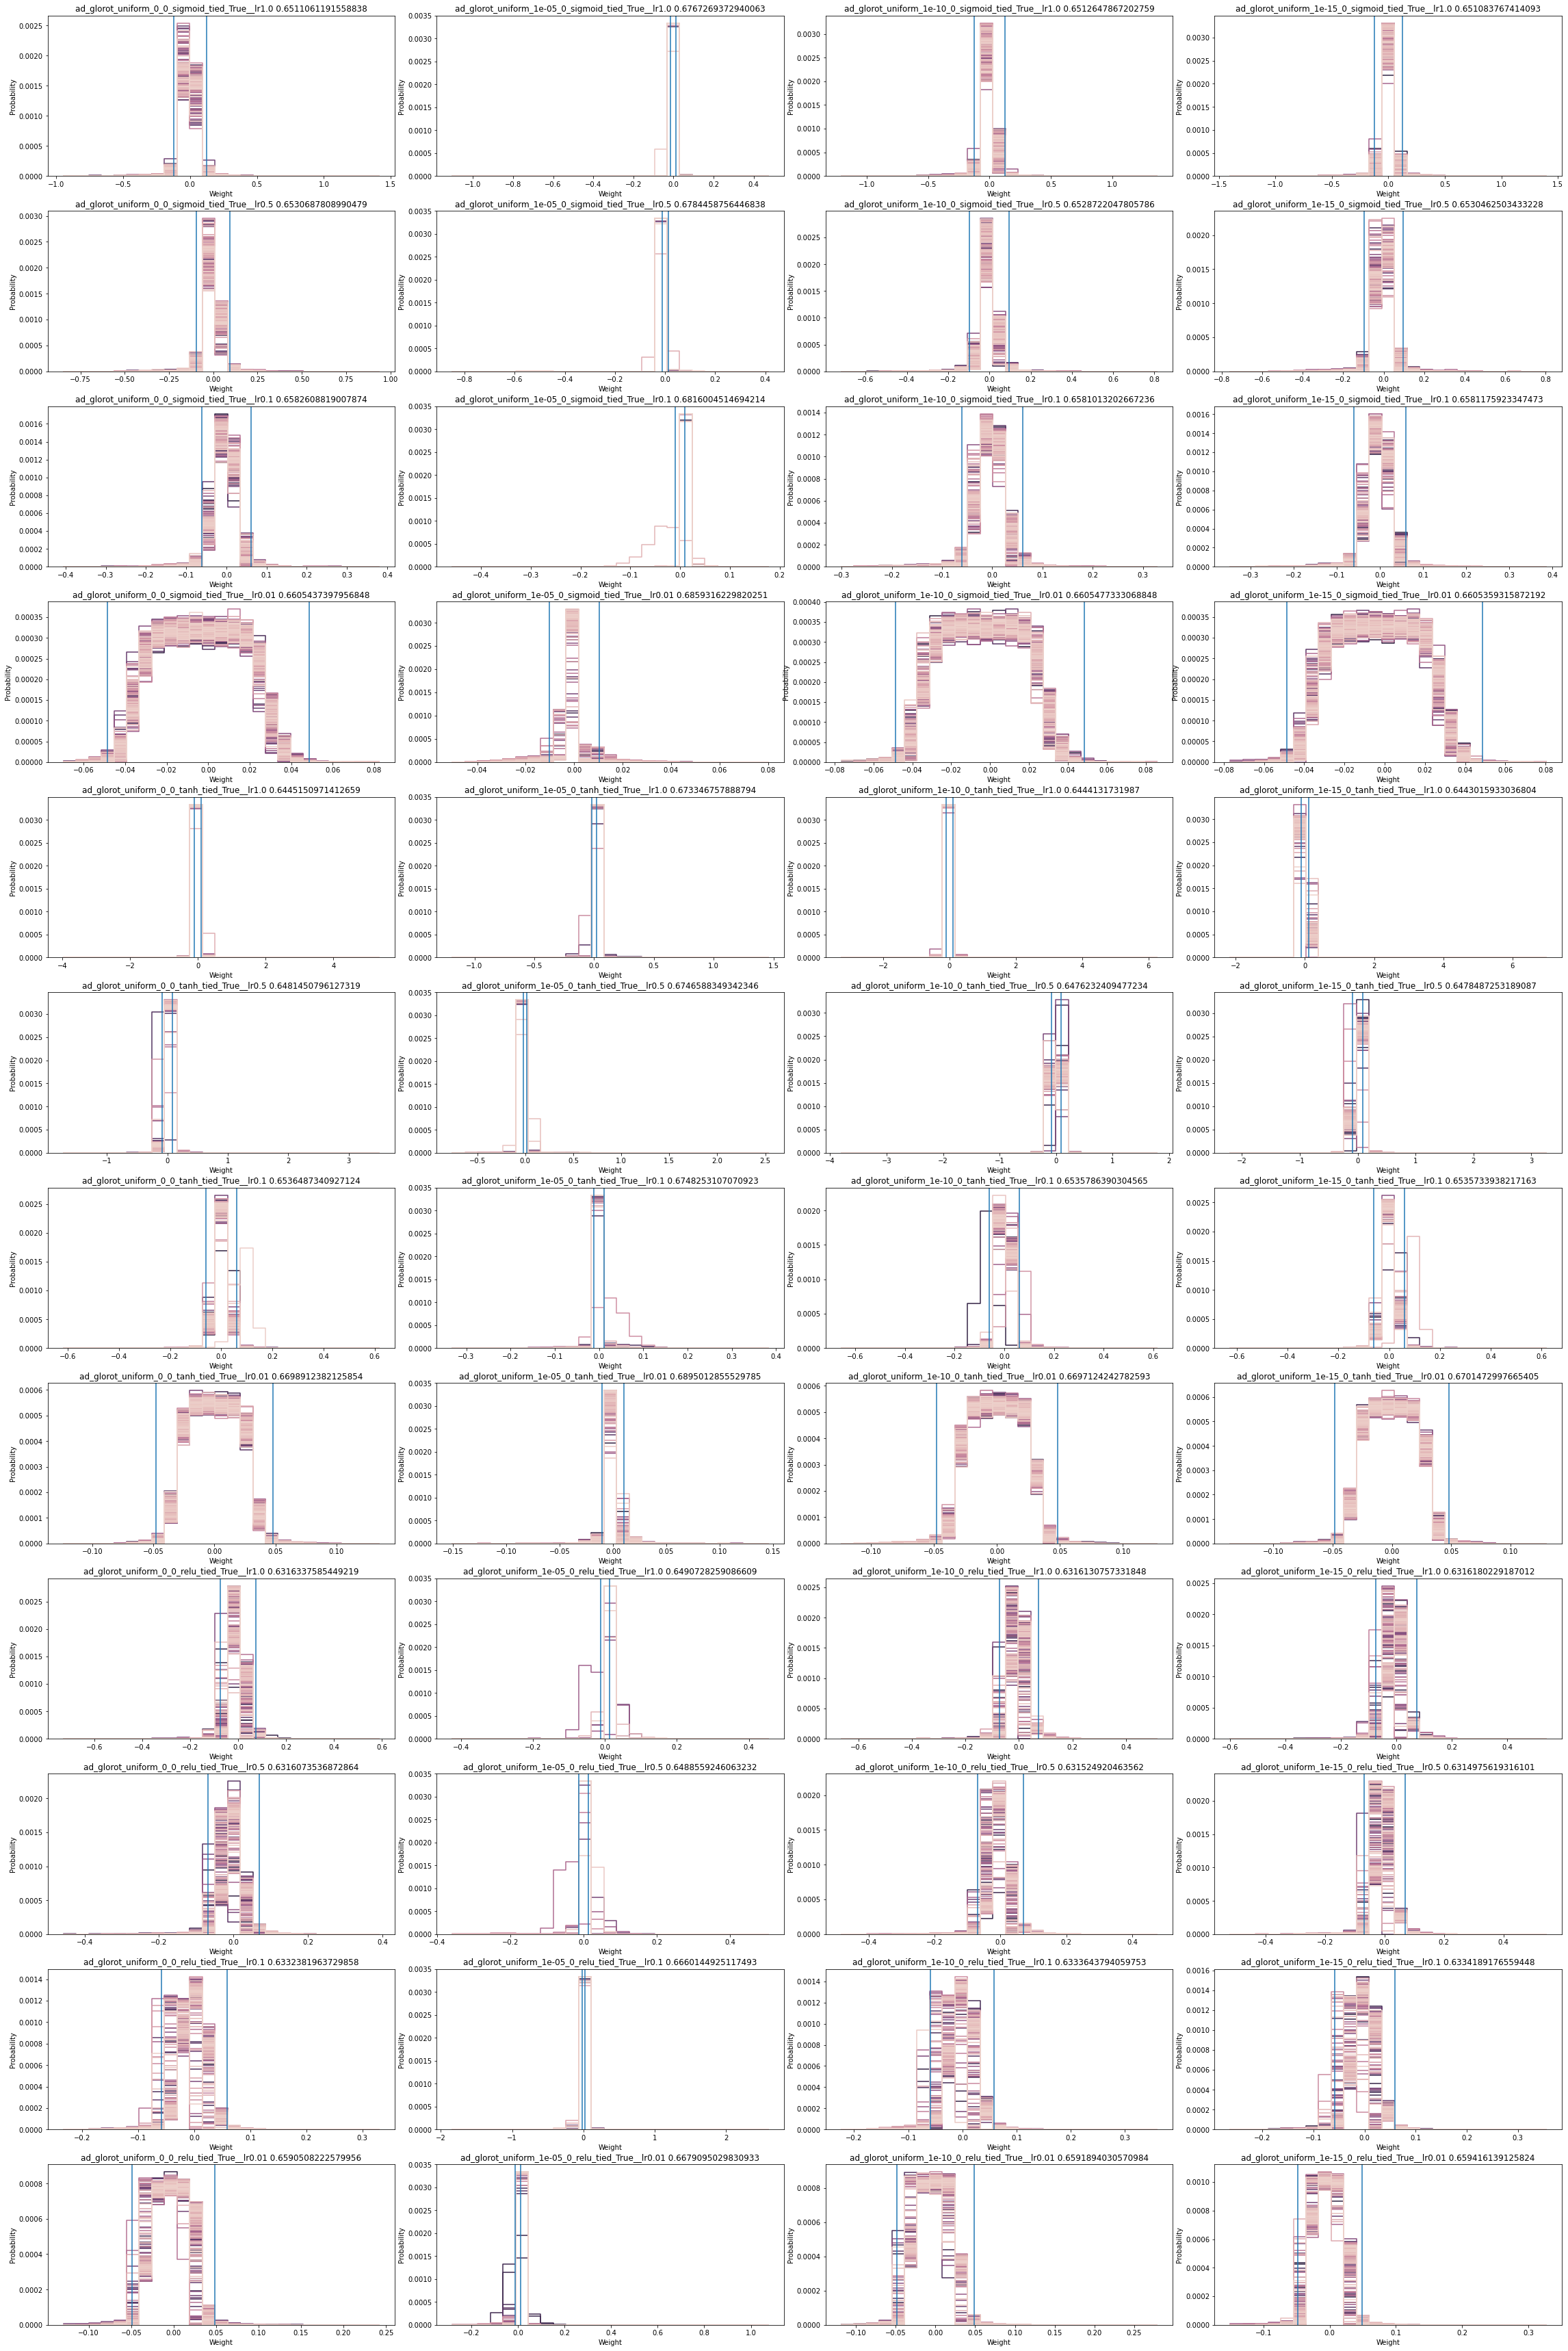

In [65]:
model_dict_temp = model_dict_da
#model_dict_temp = model_dict_da_normed
#model_dict_temp = model_dict_da_normed_sub

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,

yd = len(inits) * len(L1_norm) * len(tied) * len(L2_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        seed = str(560)
                        name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                        model_temp = model_dict_temp[name]
                        sns.histplot(pd.melt(pd.DataFrame(model_temp.weights[:,0:300])),
                         x='value', hue='variable', legend=False,element='step',fill=False,
                         ax=ax[xi,yi], bins=25, stat='probability') #, bins=50
                        ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                        ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                        ax[xi,yi].set(title =  name + " " + str(val_loss_mins[name]), xlabel = 'Weight')
                        xi = xi+1
                xi=0
                yi=yi+1


    

## 4. HWGs
### 4.1 Set gene sets

In [67]:
for m in model_dict_da:
    print(m)
    model_dict_da[m].set_hwg_cutoff(2.5)
    model_dict_da[m].set_op('../node_interpretation/operons_format.txt')
    print('op done')
    model_dict_da[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
    print('kegg done')
    model_dict_da[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
    print('go done')
    model_dict_da[m].set_reg('../node_interpretation/regulons_format.txt')
    print('reg done')
print('dict done') 

#for m in model_dict_da_normed_sub:
#    print(m)
#    model_dict_da_normed_sub[m].set_hwg_cutoff(2.5)
#    model_dict_da_normed_sub[m].set_op('../node_interpretation/operons_format.txt')
#    print('op done')
#    model_dict_da_normed_sub[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
#    print('kegg done')
#    model_dict_da_normed_sub[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
#    print('go done')
#    model_dict_da_normed_sub[m].set_reg('../node_interpretation/regulons_format.txt')
#    print('reg done')
#print('dict done') 

tf_adage
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.01
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.01
op done
kegg done
go done
re

In [60]:
#for m in model_dict_da_normed:
#    print(m)
#    model_dict_da_normed[m].set_hwg_cutoff(2.5)
#    model_dict_da_normed[m].set_op('../node_interpretation/operons_format.txt')
#    print('op done')
#    model_dict_da_normed[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
#    print('kegg done')
#    model_dict_da_normed[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
#    print('go done')
#    model_dict_da_normed[m].set_reg('../node_interpretation/regulons_format.txt')
#    print('reg done')
#print('dict done') 

tf_adage
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_tanh_tied_True__lr0.01
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr1.0
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.5
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.1
op done
kegg done
go done
reg done
ad_glorot_uniform_0_0_relu_tied_True__lr0.01
op done
kegg done
go done
re

In [ ]:
#for m in model_dict_da_normed_sub:
#    print(m)
#    model_dict_da_normed_sub[m].set_hwg_cutoff(2.5)
#    model_dict_da_normed_sub[m].set_op('../node_interpretation/operons_format.txt')
#    print('op done')
#    model_dict_da_normed_sub[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
#    print('kegg done')
#    model_dict_da_normed_sub[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
#    print('go done')
#    model_dict_da_normed_sub[m].set_reg('../node_interpretation/regulons_format.txt')
#    print('reg done')
#print('dict done') 

## 5. Plot signature enrichments
#### 5.1 For models with data scaled by matrix

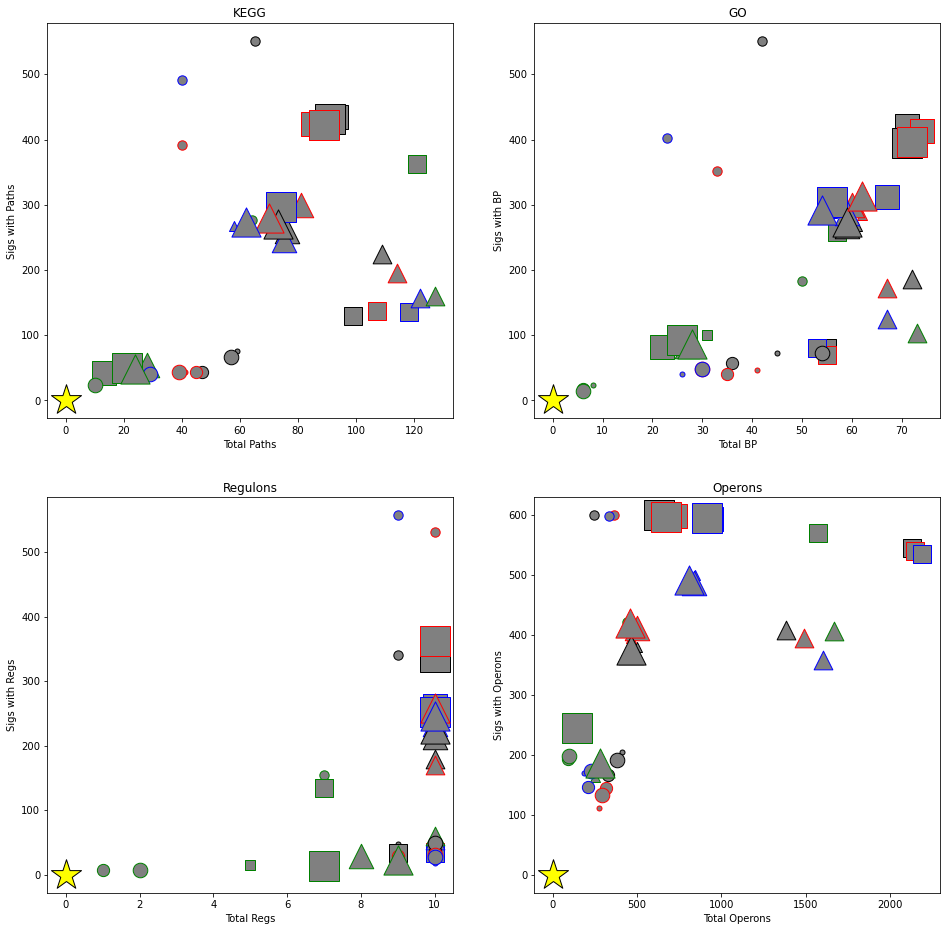

In [75]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(1):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                    #print(name)
                    model_temp = model_dict_da[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



#### 5.1 For models with data scaled by gene

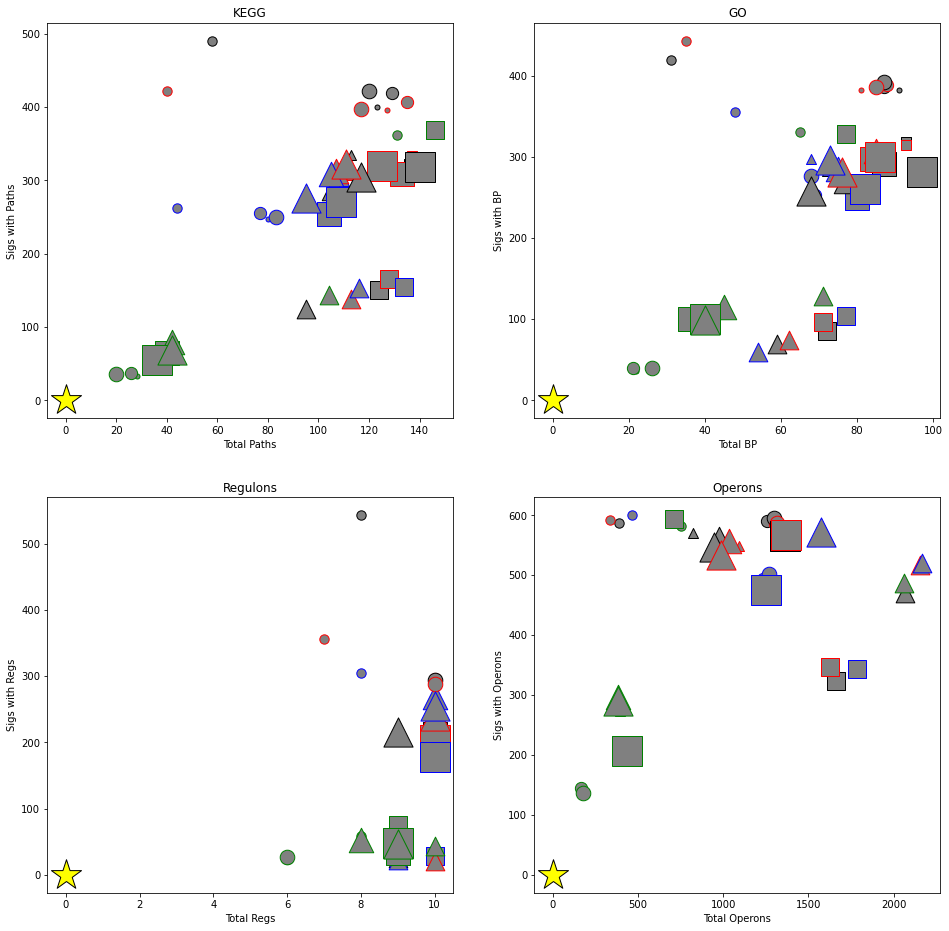

In [62]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_normed['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_normed['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_normed['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da_normed['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(1):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                    #print(name)
                    model_temp = model_dict_da_normed[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



#### 5.1 For models with data scaled by experiment

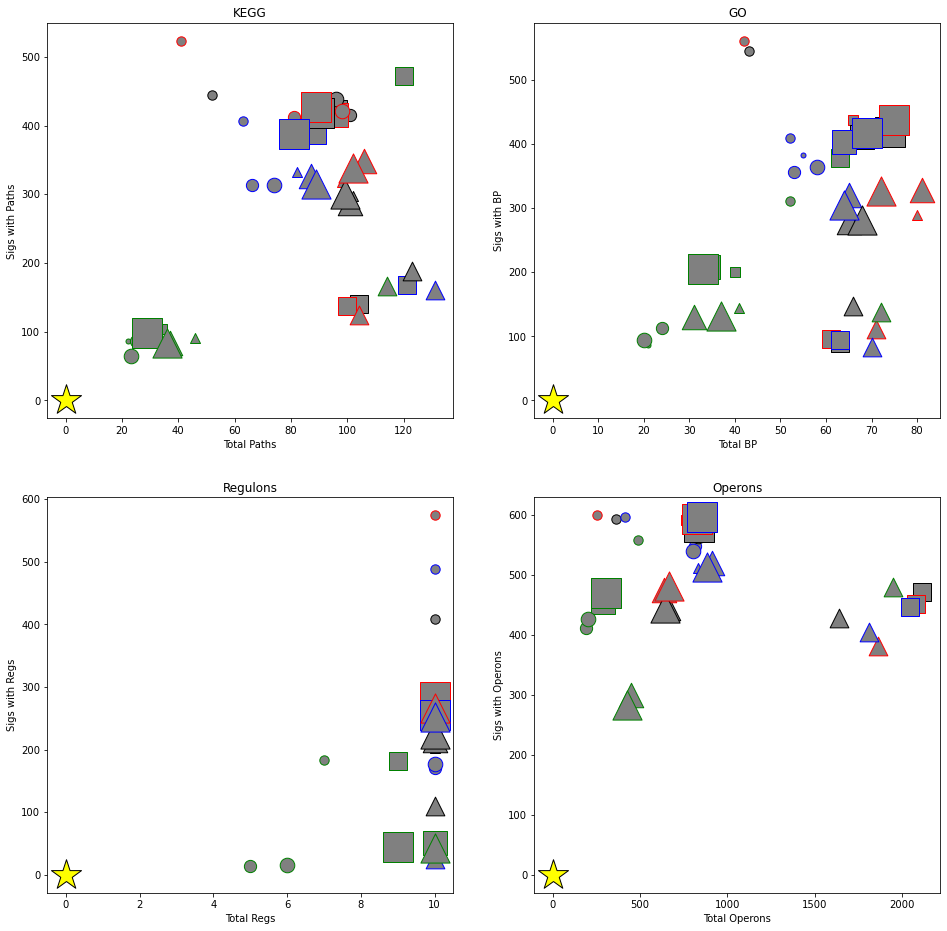

In [74]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_normed['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_normed['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_normed['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da_normed['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da_normed['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(1):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) 
                    #print(name)
                    model_temp = model_dict_da_normed_sub[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



## 6. Replicate models (3 different seeds per param combo)
### 6.1 Load models seeds 660 - 662

In [3]:
inits = ['glorot_uniform','glorot_normal']
L1_norm = [0, 1e-5, 1e-10] # 
L2_norm = [0, 1e-5, 1e-10]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.0001] 

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,



model_dict_da_reps = {
    "tf_adage": tf_adage
}

#model_dict_da_normed = {
#    "tf_adage": tf_adage
#}

#model_dict_da_normed_sub = {
#    "tf_adage": tf_adage
#}


for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        for r in range(3):
                            seed = str(660 + r)
                            name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) +'_r:' + seed
                            #model_dict_da
                            prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_byall_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                            #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                            #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_bygene_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                            try:
                                weights_temp = np.array(pd.read_csv('../outputs/weights/' + prefix + '_en_weights_da.csv', header = None))
                                loss_temp = np.array(pd.read_csv('../outputs/loss/' + prefix + '_loss_da.csv', header = None))
                                val_loss_temp = np.array(pd.read_csv('../outputs/val_loss/' + prefix + '_val_loss_da.csv', header = None))
                                adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
                                adage_temp.weights = weights_temp
                                adage_temp.loss = loss_temp[0]
                                adage_temp.val_loss = val_loss_temp[0]
                                adage_temp.set_hwg_cutoff(2.5)
                                model_dict_da_reps[name] = adage_temp
                                #model_dict_da_normed[name] = adage_temp
                                #model_dict_da_normed_sub[name] = adage_temp
                            except:
                                print(name)
                                adage_temp = tf_adage
                                adage_temp.loss = [0] * 250
                                adage_temp.val_loss = [0] * 250
                                adage_temp.weights = np.zeros(tf_adage.weights.shape)
                                model_dict_da_reps[name] = adage_temp
                                #model_dict_da_normed[name] = adage_temp
                                #model_dict_da_normed_sub[name] = adage_temp
                        





ad_glorot_uniform_1e-05_0_sigmoid_tied_True__lr0.5_r:661
ad_glorot_uniform_1e-05_0_sigmoid_tied_True__lr0.1_r:661
ad_glorot_uniform_1e-05_0_sigmoid_tied_True__lr0.01_r:661
ad_glorot_uniform_1e-05_0_tanh_tied_True__lr1.0_r:661
ad_glorot_uniform_1e-05_0_tanh_tied_True__lr0.5_r:661
ad_glorot_uniform_1e-05_0_tanh_tied_True__lr0.1_r:661
ad_glorot_uniform_1e-05_0_tanh_tied_True__lr0.01_r:661
ad_glorot_uniform_1e-05_0_relu_tied_True__lr1.0_r:661
ad_glorot_uniform_1e-05_0_relu_tied_True__lr0.5_r:661
ad_glorot_uniform_1e-05_0_relu_tied_True__lr0.01_r:661
ad_glorot_uniform_1e-10_0_sigmoid_tied_True__lr1.0_r:661
ad_glorot_uniform_1e-10_0_sigmoid_tied_True__lr0.5_r:661
ad_glorot_uniform_1e-10_0_sigmoid_tied_True__lr0.1_r:661
ad_glorot_uniform_1e-10_0_sigmoid_tied_True__lr0.01_r:661
ad_glorot_uniform_1e-10_0_tanh_tied_True__lr1.0_r:661
ad_glorot_uniform_1e-10_0_tanh_tied_True__lr0.5_r:661
ad_glorot_uniform_1e-10_0_tanh_tied_True__lr0.1_r:661
ad_glorot_uniform_1e-10_0_tanh_tied_True__lr0.01_r:661
ad

### 6.2 Plot loss curves

0.6202069520950317
0.9559763669967652


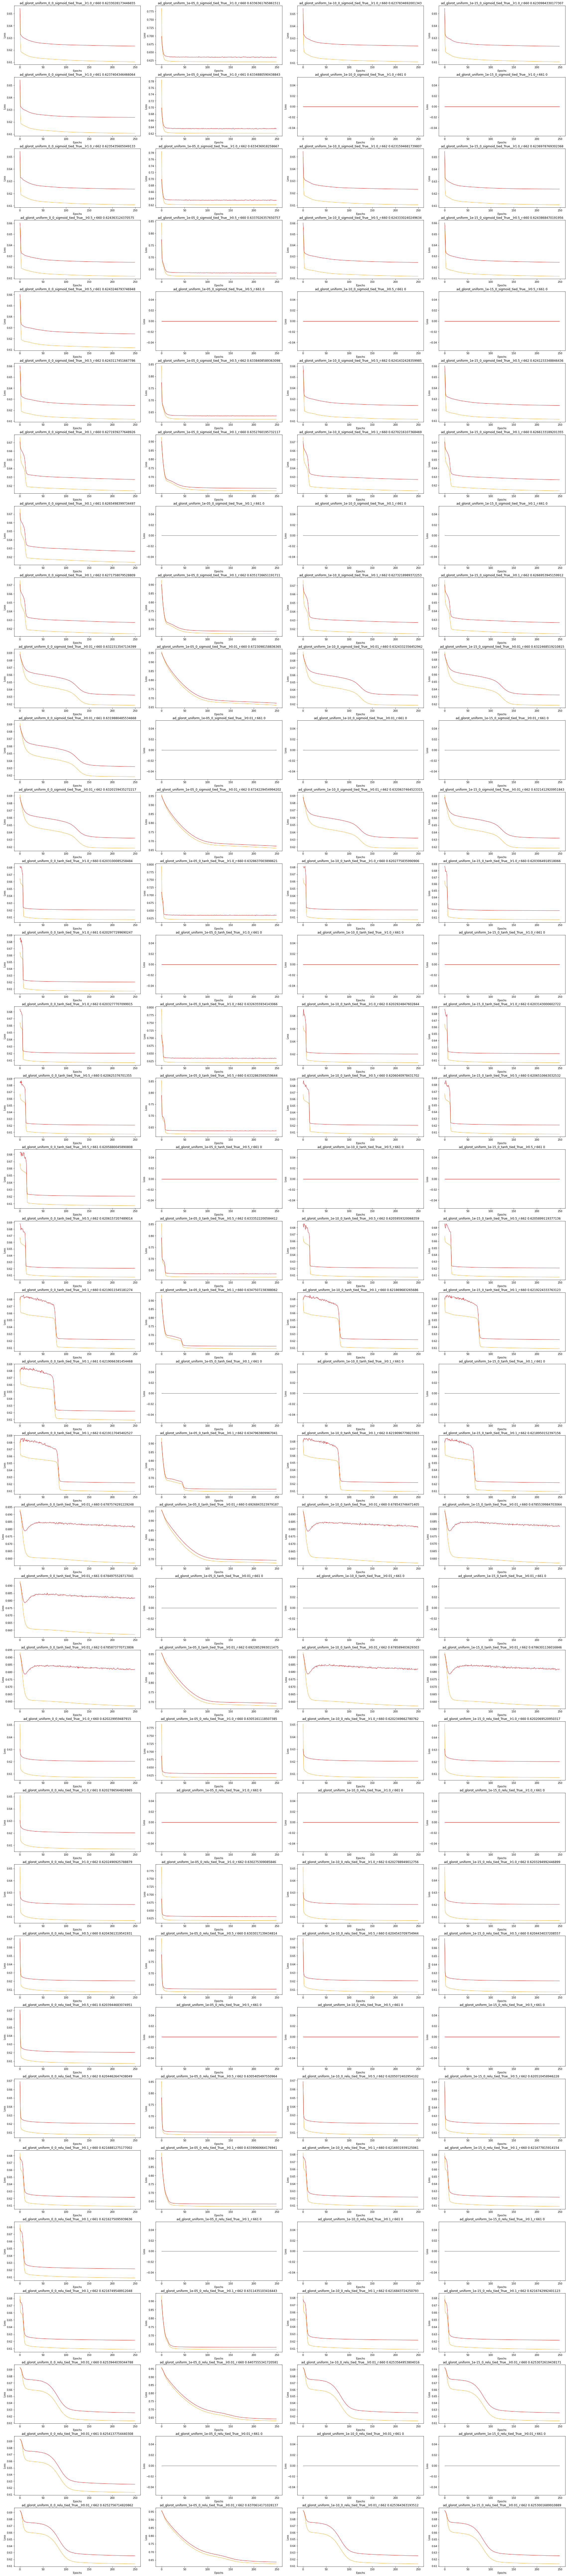

In [77]:
model_dict_temp = model_dict_da_reps
#model_dict_temp = model_dict_da_normed
#model_dict_temp = model_dict_da_normed_sub
minn=float('inf')
for mo in model_dict_temp.keys():
    minn_t = min(model_dict_temp[mo].val_loss)
    if(minn_t > 0):
        minn = min(minn, minn_t)

maxx=float('-inf')
for mo in model_dict_temp.keys():
    maxx_t = max(model_dict_temp[mo].val_loss)
    maxx = max(maxx, maxx_t)

print(minn)
print(maxx)

val_loss_mins = {}
for mo in model_dict_temp.keys():
    val_loss_mins[mo] = min(model_dict_temp[mo].val_loss)
    
    
inits = ['glorot_uniform'] #,'glorot_normal'
L1_norm = [0, 1e-5] # , 1e-10
L2_norm = [0, 1e-5] # , 1e-10
act_fun = ['sigmoid', 'tanh', 'relu'] # , 'tanh','relu'
tied = [True] #, False
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.0001] 

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,

yd = len(inits) * len(L1_norm) * len(tied) * len(L2_norm)
xd = len(act_fun) * len(lr) * 3
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        for r in range(3):
                            seed = str(660+r)
                            name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) + '_r:' + seed 
                            model_temp = model_dict_temp[name]
                            ax[xi,yi].plot(list(range(0,250)), model_temp.loss[:250], linewidth=1, markersize=2, color = 'orange')
                            ax[xi,yi].plot(list(range(0,250)), model_temp.val_loss[:250], linewidth=1, markersize=2, color = 'red')
                            ax[xi,yi].set(title = name + " " + str(val_loss_mins[name]), xlabel = 'Epochs', ylabel = 'Loss')
                            #ax[xi,yi].set_ylim(minn,maxx)
                            xi = xi+1
                xi=0
                yi=yi+1


    

### 6.3 Plot loss mins

In [78]:
val_loss_mins = {}
for mo in model_dict_da_reps.keys():
    val_loss_mins[mo] = min(model_dict_da_reps[mo].val_loss)
val_loss_mins

{'tf_adage': 0,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:660': 0.6233028173446655,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:661': 0.6237404346466064,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:662': 0.6235435605049133,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:660': 0.624363124370575,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:661': 0.6243246793746948,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:662': 0.6243117451667786,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:660': 0.6271939277648926,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:661': 0.6265498399734497,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:662': 0.6271758079528809,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:660': 0.6322313547134399,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:661': 0.6319880485534668,
 'ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:662': 0.6320159435272217,
 'ad_glorot_uniform_0_0_tanh_tied_True__lr1.0_r:660': 0.62

### 6.4 Plot weight distributions

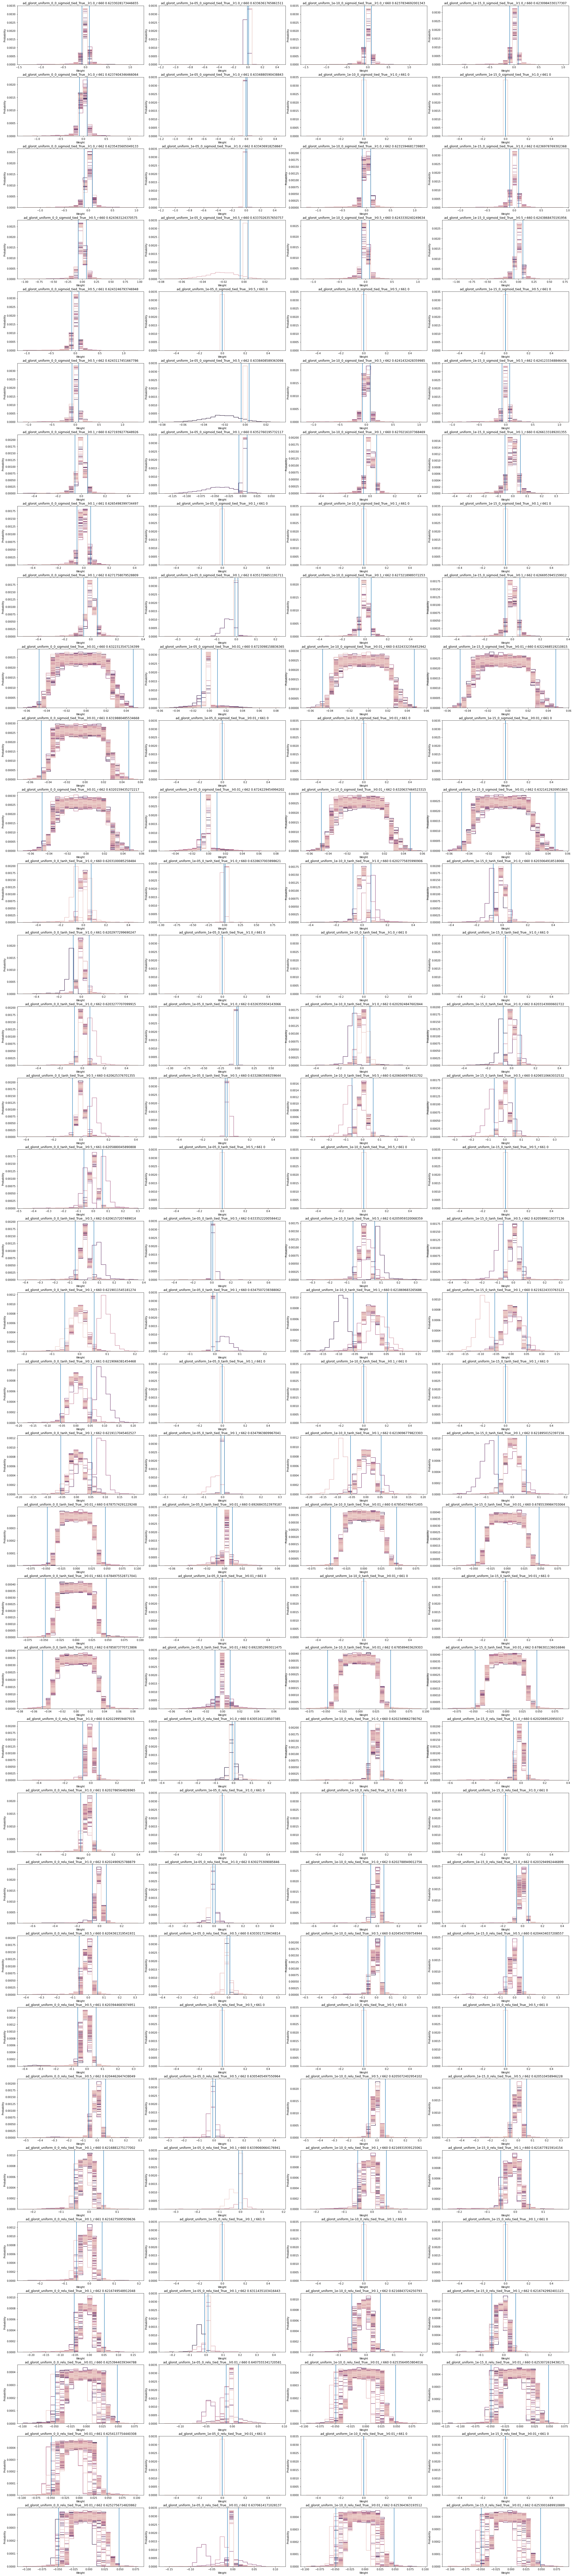

In [81]:
model_dict_temp = model_dict_da_reps
#model_dict_temp = model_dict_da_normed
#model_dict_temp = model_dict_da_normed_sub

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,

yd = len(inits) * len(L1_norm) * len(tied) * len(L2_norm)
xd = len(act_fun) * len(lr) * 3
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for w in tied:
    for i in inits:
        for l in L1_norm:
            for n in L2_norm:
                for a in act_fun:
                    for t in lr:
                        for r in range(3):
                            seed = str(660+r)
                            name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) + '_r:' + seed 
                            model_temp = model_dict_temp[name]
                            sns.histplot(pd.melt(pd.DataFrame(model_temp.weights[:,0:300])),
                            x='value', hue='variable', legend=False,element='step',fill=False,
                            ax=ax[xi,yi], bins=25, stat='probability') #, bins=50
                            ax[xi,yi].axvline(x = np.std(model_temp.weights)*2.5)
                            ax[xi,yi].axvline(x = np.std(model_temp.weights)*-2.5)
                            ax[xi,yi].set(title =  name + " " + str(val_loss_mins[name]), xlabel = 'Weight')
                            xi = xi+1
                xi=0
                yi=yi+1


    

### 6.5 Calculate signature enrichment

In [83]:
for m in model_dict_da_reps:
    print(m)
    model_dict_da_reps[m].set_hwg_cutoff(2.5)
    model_dict_da_reps[m].set_op('../node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_da_reps[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_da_reps[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_da_reps[m].set_reg('../node_interpretation/regulons_format.txt')
    #print('reg done')
print('dict done') 

tf_adage
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:660
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:661
ad_glorot_uniform_0_0_sigmoid_tied_True__lr1.0_r:662
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:660
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:661
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.5_r:662
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:660
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:661
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.1_r:662
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:660
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:661
ad_glorot_uniform_0_0_sigmoid_tied_True__lr0.01_r:662
ad_glorot_uniform_0_0_tanh_tied_True__lr1.0_r:660
ad_glorot_uniform_0_0_tanh_tied_True__lr1.0_r:661
ad_glorot_uniform_0_0_tanh_tied_True__lr1.0_r:662
ad_glorot_uniform_0_0_tanh_tied_True__lr0.5_r:660
ad_glorot_uniform_0_0_tanh_tied_True__lr0.5_r:661
ad_glorot_uniform_0_0_tanh_tied_True__lr0.5_r:662
ad_glorot_uniform_0_0_tanh_tied_True__lr0.1_r:660
ad

### 6.6 Plot Signature enrichment (all sigs)


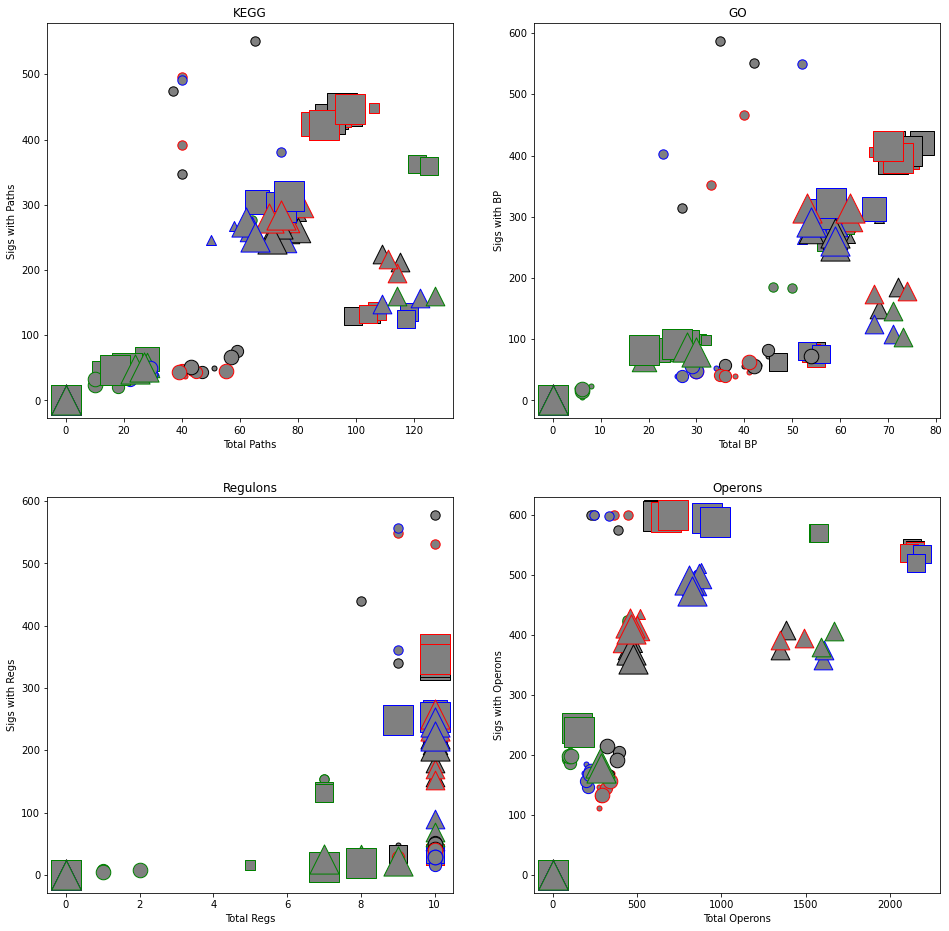

In [84]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(3):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) + '_r:' + seed 
                    #print(name)
                    model_temp = model_dict_da_reps[name]
                    x = ((model_temp.kegg_ps > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



### 6.7 Plot Signature enrichment (pos sigs only)

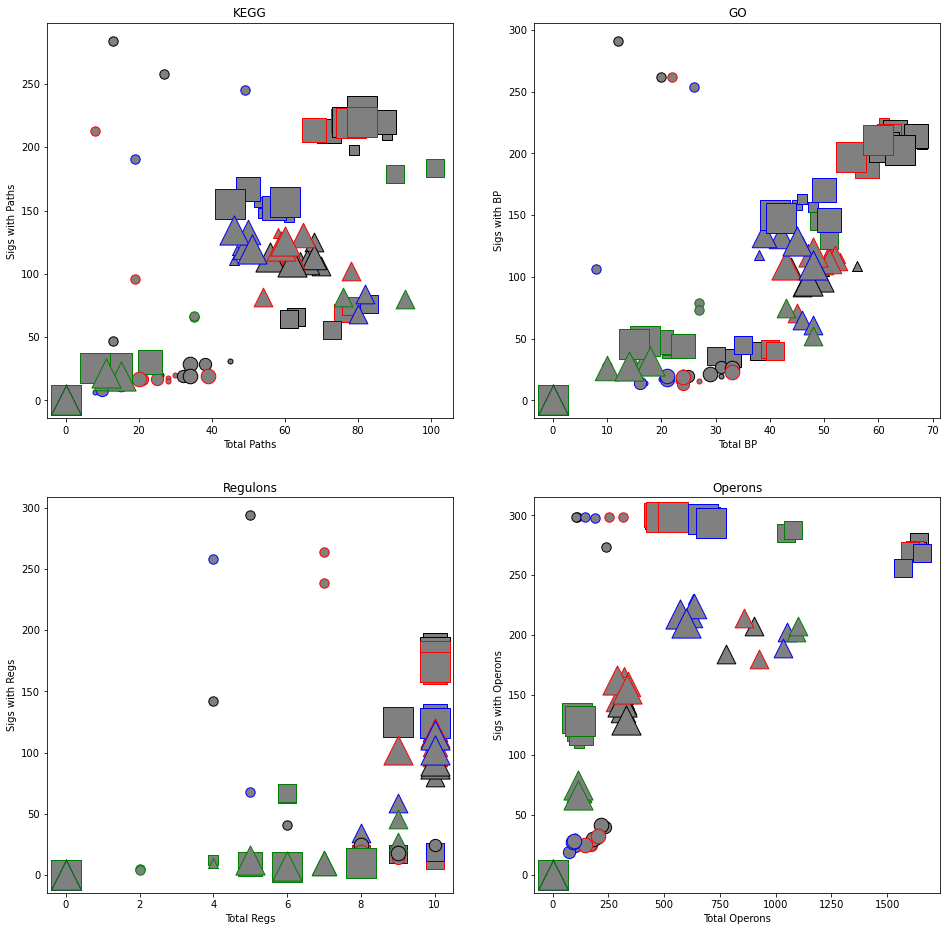

In [95]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0theme(legend.position = "none")
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(3):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) + '_r:' + seed 
                    #print(name)
                    model_temp = model_dict_da_reps[name]
                    x = ((model_temp.kegg_ps[0:300] > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps[0:300] > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps[0:300] > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps[0:300] > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps[0:300] > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps[0:300] > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps[0:300] > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps[0:300] > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



### 6.8 Plot Signature enrichment (neg sigs only)

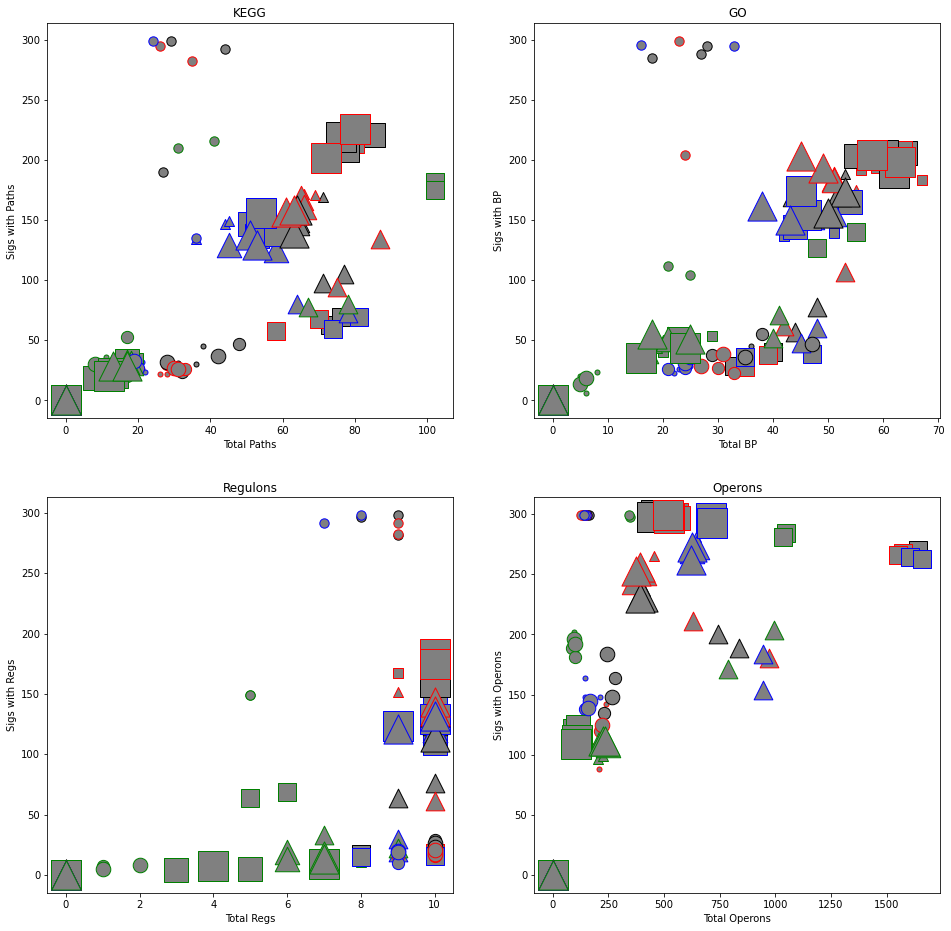

In [96]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].kegg_ps > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].go_ps > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].regs_ps > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

x = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict_da_reps['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for i in inits:
    s=100
    for l in L1_norm:
        xi = 0
        mi=0
        for a in act_fun:
            m = ms[mi]
            #ec = 'black'
            eci=0
            for t in lr:
                for se in range(3):
                    seed = str(se+660)
                    name = 'ad_' + i + '_' + str(l) + '_' + str(n) + '_' + a + '_tied' + '_' + str(w) + '_' + '_lr' + str(t) + '_r:' + seed 
                    #print(name)
                    model_temp = model_dict_da_reps[name]
                    x = ((model_temp.kegg_ps[301:600] > plimk).sum(0) > 0).sum()
                    y = ((model_temp.kegg_ps[301:600] > plimk).sum(1) > 0).sum()
                    ax[0,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.go_ps[301:600] > plimg).sum(0) > 0).sum()
                    y = ((model_temp.go_ps[301:600] > plimg).sum(1) > 0).sum()
                    ax[0,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.regs_ps[301:600] > plimr).sum(0) > 0).sum()
                    y = ((model_temp.regs_ps[301:600] > plimr).sum(1) > 0).sum()
                    ax[1,0].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)
                    
                    x = ((model_temp.ops_ps[301:600] > plimo).sum(0) > 0).sum()
                    y = ((model_temp.ops_ps[301:600] > plimo).sum(1) > 0).sum()
                    ax[1,1].scatter(x, y, c = c, marker = m, edgecolor = ec[eci], s=s)

                eci = eci+1
            mi = mi+1
        s=s+250
    c = 'grey'



size = L1 norm (small to large, 0,1e-5,1e-10,1e-15)
edge color = learning rate (black: 1, red:.5,blue: .1, green: .01)
shape = activation funciton (circle: sigmoid, square: tanh, triangle: relu)

## 7. Chosen params
In the absence of a real grid search for optimal parameters...

### 7.1 Load 10 replicate models 

In [15]:
inits = ['glorot_uniform','glorot_normal']
L1_norm = [0, 1e-5, 1e-10] # 
L2_norm = [0, 1e-5, 1e-10]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True, False]
lr = [1.5,1.0,0.5,0.1,0.01,0.001,0.0001] 

inits = ['glorot_uniform']
L1_norm = [0, 1e-5, 1e-10,1e-15]
L2_norm = [0]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [1.0,0.5,0.1,0.01] #1.5,



model_dict_da_ens = {
    "tf_adage": tf_adage
}


for r in range(10):
    seed = str(660 + r)
    name = 'seed:' + seed
    prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_byall_seed:' + seed + '_kl1:' + str(1e-5) + '_kl2:0_act:' + 'relu' + '_init:' + 'glorot_uniform' + '_ep:250_tied:' + str(True) + '_batch:10_lr:' + str(0.1)
                            #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
                            #prefix = '/data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01_bygene_seed:' + seed + '_kl1:' + str(l) + '_kl2:0_act:' + a + '_init:' + i + '_ep:250_tied:' + str(w) + '_batch:10_lr:' + str(t)
    weights_temp = np.array(pd.read_csv('../outputs/weights/' + prefix + '_en_weights_da.csv', header = None))
    loss_temp = np.array(pd.read_csv('../outputs/loss/' + prefix + '_loss_da.csv', header = None))
    val_loss_temp = np.array(pd.read_csv('../outputs/val_loss/' + prefix + '_val_loss_da.csv', header = None))
    adage_temp = Adage.Adage(tf_adage.autoencoder, tf_adage.history, tf_adage.compendium)
    adage_temp.weights = weights_temp
    adage_temp.loss = loss_temp[0]
    adage_temp.val_loss = val_loss_temp[0]
    adage_temp.set_hwg_cutoff(2.5)
    model_dict_da_ens[name] = adage_temp




### 7.2 Plot loss curves for 10 rep models

0.6311895251274109
9.834694862365723


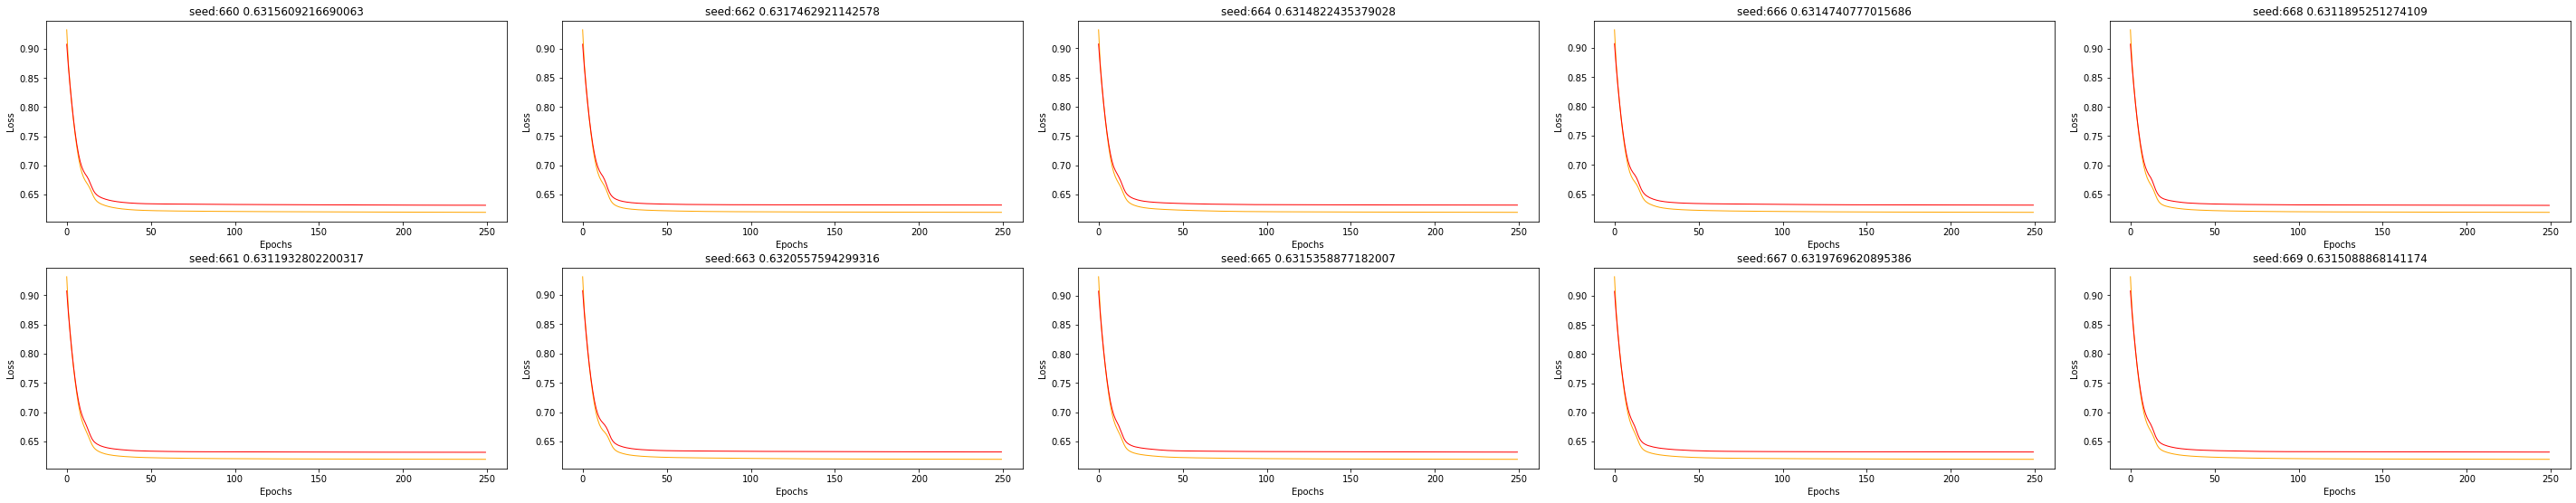

In [16]:
model_dict_temp = model_dict_da_ens

minn=float('inf')
for mo in model_dict_temp.keys():
    minn_t = min(model_dict_temp[mo].val_loss)
    if(minn_t > 0):
        minn = min(minn, minn_t)

maxx=float('-inf')
for mo in model_dict_temp.keys():
    maxx_t = max(model_dict_temp[mo].val_loss)
    maxx = max(maxx, maxx_t)

print(minn)
print(maxx)

val_loss_mins = {}
for mo in model_dict_temp.keys():
    val_loss_mins[mo] = min(model_dict_temp[mo].val_loss)
    


yd = 5
xd = 2
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

r=0
for i in range(5):
    for j in range(2):
        seed = str(660+r)
        name = 'seed:' + seed                            
        model_temp = model_dict_temp[name]
        ax[j,i].plot(list(range(0,250)), model_temp.loss[:250], linewidth=1, markersize=2, color = 'orange')
        ax[j,i].plot(list(range(0,250)), model_temp.val_loss[:250], linewidth=1, markersize=2, color = 'red')
        ax[j,i].set(title = name + " " + str(val_loss_mins[name]), xlabel = 'Epochs', ylabel = 'Loss')
        r = r+1



    

### 7.3 Plot weight distributions

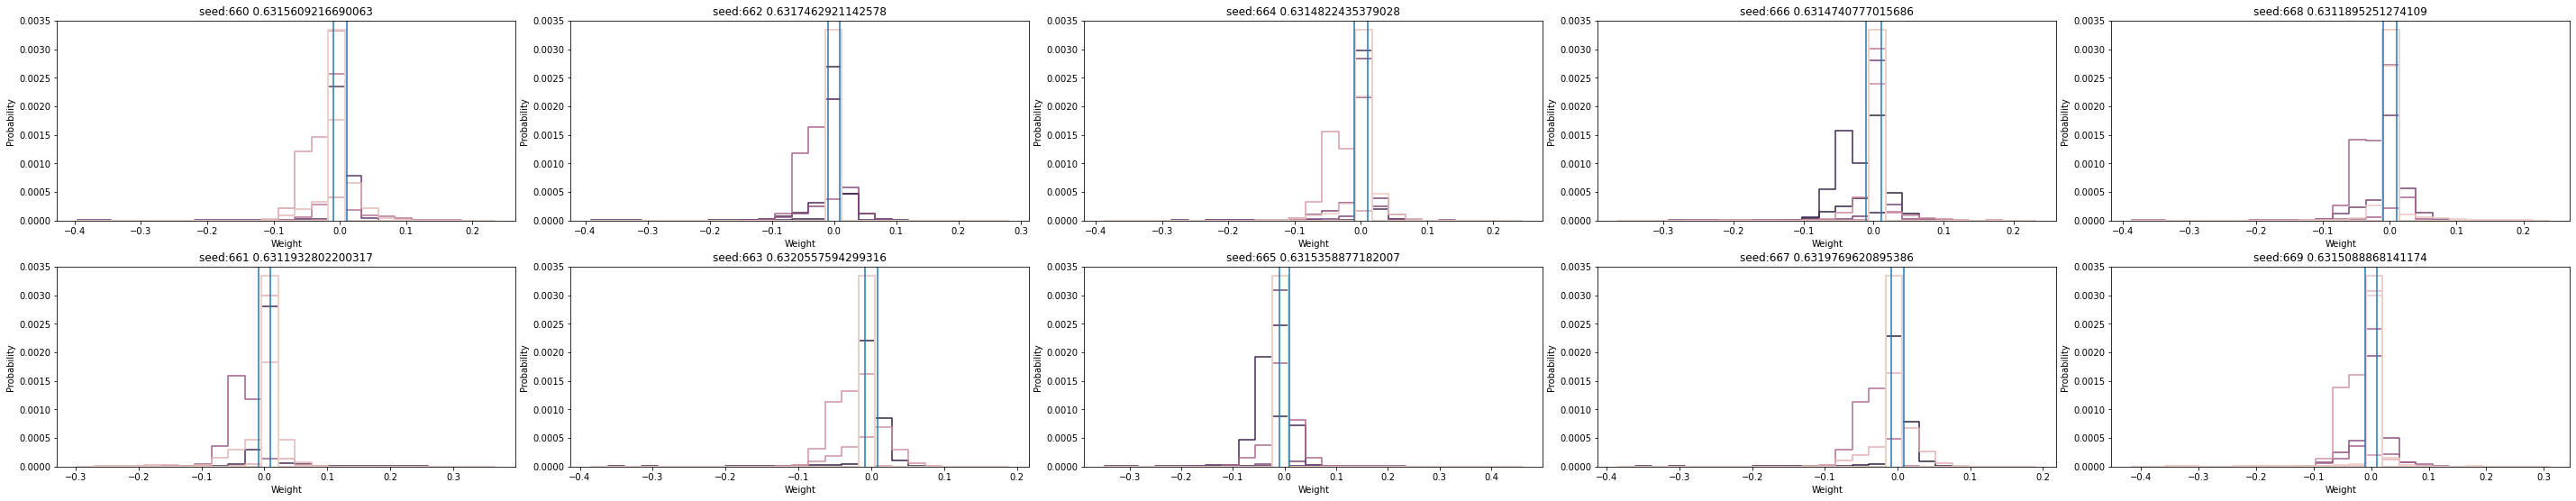

In [6]:
yd = 5
xd = 2
fig, ax = plt.subplots(xd, yd,figsize=(yd*8 ,xd *4))
fig.tight_layout(pad=3.0)

r=0
for i in range(5):
    for j in range(2):
        seed = str(660+r)
        name = 'seed:' + seed                            
        model_temp = model_dict_temp[name]                            
        sns.histplot(pd.melt(pd.DataFrame(model_temp.weights[:,0:300])),
                            x='value', hue='variable', legend=False,element='step',fill=False,
                            ax=ax[j,i], bins=25, stat='probability') #, bins=50
        ax[j,i].axvline(x = np.std(model_temp.weights)*2.5)
        ax[j,i].axvline(x = np.std(model_temp.weights)*-2.5)
        ax[j,i].set(title =  name + " " + str(val_loss_mins[name]), xlabel = 'Weight')
        r = r+1

In [12]:
model_dict_da_ens['tf_adage'] = tf_adage

In [ ]:
### 7.4 Siganture enrichment

In [20]:
for m in model_dict_da_ens:
    print(m)
    model_dict_da_ens[m].set_hwg_cutoff(2.5)
    model_dict_da_ens[m].set_op('../node_interpretation/operons_format.txt')
    #print('op done')
    model_dict_da_ens[m].set_kegg('../node_interpretation/pseudomonas_KEGG_terms.txt') 
    #print('kegg done')
    model_dict_da_ens[m].set_go('../node_interpretation/manual_GO_BP_terms.txt') 
    #print('go done')
    model_dict_da_ens[m].set_reg('../node_interpretation/regulons_format.txt')
    #print('reg done')
print('dict done') 

tf_adage
seed:660
seed:661
seed:662
seed:663
seed:664
seed:665
seed:666
seed:667
seed:668
seed:669
dict done


In [46]:
((model_dict_da_ens['seed:660'].kegg_ps[0:600] > plimk).sum(0) > 0)

0
KEGG-Pathway-pae00072: Synthesis and degradation of ketone bodies - Pseudomonas aeruginosa PAO1     True
KEGG-Pathway-pae00071: Fatty acid degradation - Pseudomonas aeruginosa PAO1                        False
KEGG-Pathway-pae00903: Limonene and pinene degradation - Pseudomonas aeruginosa PAO1                True
KEGG-Pathway-pae00380: Tryptophan metabolism - Pseudomonas aeruginosa PAO1                          True
KEGG-Pathway-pae00900: Terpenoid backbone biosynthesis - Pseudomonas aeruginosa PAO1                True
                                                                                                   ...  
KEGG-Module-M00742: Aminoglycoside resistance, protease FtsH                                       False
KEGG-Module-M00003: Gluconeogenesis, oxaloacetate => fructose-6P                                   False
KEGG-Module-M00709: Macrolide resistance, MacAB-TolC transporter                                   False
KEGG-Module-M00718: Multidrug resistance, efflux pump

### 7.5 Plot Signature enrichment

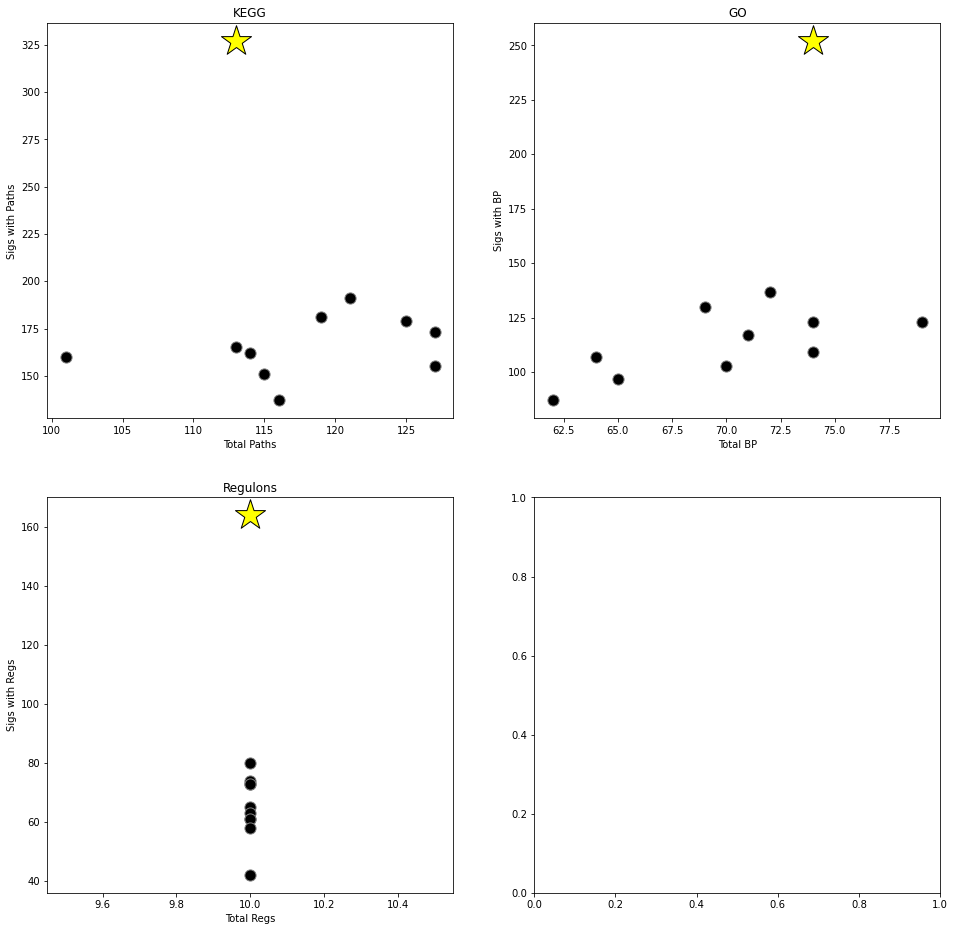

In [21]:

plimk=5
plimg=5
plimr=5
plimo=5
xd=2
yd=2
fig, ax = plt.subplots(xd,yd,figsize=(xd*8 ,yd *8))
x = ((model_dict_da_ens['tf_adage'].kegg_ps[0:600] > plimk).sum(0) > 0).sum()
y = ((model_dict_da_ens['tf_adage'].kegg_ps[0:600] > plimk).sum(1) > 0).sum()
ax[0,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,0].set(title = 'KEGG', xlabel = 'Total Paths', ylabel = 'Sigs with Paths')

x = ((model_dict_da_ens['tf_adage'].go_ps[0:600] > plimg).sum(0) > 0).sum()
y = ((model_dict_da_ens['tf_adage'].go_ps[0:600] > plimg).sum(1) > 0).sum()
ax[0,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[0,1].set(title = 'GO', xlabel = 'Total BP', ylabel = 'Sigs with BP')

x = ((model_dict_da_ens['tf_adage'].regs_ps[0:600] > plimr).sum(0) > 0).sum()
y = ((model_dict_da_ens['tf_adage'].regs_ps[0:600] > plimr).sum(1) > 0).sum()
ax[1,0].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
ax[1,0].set(title = 'Regulons', xlabel = 'Total Regs', ylabel = 'Sigs with Regs')

#x = ((model_dict_da_ens['tf_adage'].ops_ps > plimo).sum(0) > 0).sum()
#y = ((model_dict_da_ens['tf_adage'].ops_ps > plimo).sum(1) > 0).sum()
#ax[1,1].scatter(x, y, c = 'yellow', marker = '*', edgecolor ='black', s=1000)
#ax[1,1].set(title = 'Operons', xlabel = 'Total Operons', ylabel = 'Sigs with Operons')

xi = 0
yi = 0
c = 'grey'
ec = ['black','red','blue','green','purple']
eci=0
ms = ['.','s', '^','h']
mi=0
s=50
for r in range(10):
    seed = str(r+660)
    name = 'seed:' + seed   
    model_temp = model_dict_da_ens[name]
    x = ((model_temp.kegg_ps[0:600] > plimk).sum(0) > 0).sum()
    y = ((model_temp.kegg_ps[0:600] > plimk).sum(1) > 0).sum()
    ax[0,0].scatter(x, y, c = 'black', marker = '.', edgecolor = 'grey', s=500)
                    
    x = ((model_temp.go_ps[0:600] > plimg).sum(0) > 0).sum()
    y = ((model_temp.go_ps[0:600] > plimg).sum(1) > 0).sum()
    ax[0,1].scatter(x, y, c = 'black', marker = '.', edgecolor = 'grey', s=500)
                    
    x = ((model_temp.regs_ps[0:600] > plimr).sum(0) > 0).sum()
    y = ((model_temp.regs_ps[0:600] > plimr).sum(1) > 0).sum()
    ax[1,0].scatter(x, y, c = 'black', marker = '.', edgecolor = 'grey', s=500)
                    
    #x = ((model_temp.ops_ps[301:600] > plimo).sum(0) > 0).sum()
    #y = ((model_temp.ops_ps[301:600] > plimo).sum(1) > 0).sum()
    #ax[1,1].scatter(x, y, c = 'black', marker = '.', edgecolor = 'grey', s=500)



### 7.6 Save signature enrichment matrices

In [49]:
name = 'seed:660'
model_temp = model_dict_da_ens[name]
#model_temp = model_dict3[name]

node_paths_list=[]
for n in range(model_temp.hw_genes_all.shape[1]):
    paths_temp = ['node'+str(n)]
    for k in range(model_temp.kegg_ps.shape[1]):
        if(model_temp.kegg_ps.loc[n][k] > -np.log(0.01)):
            paths_temp.append(model_temp.kegg_ps.columns[k])
    node_paths_list.append(paths_temp)
node_paths_list

with open("seed_660_kegg.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(node_paths_list)

### 7.7 Save high weight gene weights and lists

In [6]:
model_names = model_dict_da_ens.keys()
hwgc = 2.5

for m in model_names:
    #model_temp = model_dict_seq3[name]
    model_temp = model_dict_da_ens[m]
    model_temp.set_hwg_cutoff(hwgc)
    hw_gene_lists = []
    weight_lists = []
    for n in range(model_temp.hw_genes_all.shape[1]):
        genes_temp = ['node'+str(n)]
        weights_temp = [1]
        for g in range(model_temp.hw_genes_all.shape[0]):
            if(model_temp.hw_genes_all[g,n]):
                #print(g)
                genes_temp.append(model_temp.compendium.index[g])
                weights_temp.append(abs(model_temp.weights[g,n % model_temp.weights.shape[1]]))

        genes_temp_sorted = [x for _,x in sorted(zip(weights_temp, genes_temp), reverse=True)]
        weights_temp_sorted = [x for _,x in sorted(zip(weights_temp, weights_temp), reverse=True)]
        hw_gene_lists.append(genes_temp_sorted)
        weight_lists.append(weights_temp_sorted)
        
    hw_gene_df = pd.DataFrame(hw_gene_lists).fillna('').values  
    hw_weight_df = pd.DataFrame(weight_lists).fillna(0).values  
    #hw_gene_lists[1]
    #write_data('test_hwgs.csv', hw_gene_lists)
    with open( 'new_models/' + m + "seq_hwgs_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_gene_df)
    with open(  'new_models/' + m + "seq_hwg_weights_" + str(hwgc) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(hw_weight_df)
        
    with open(  'new_models/' + m + "seq_weights.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(model_temp.weights)

KeyboardInterrupt: 